# Introduction
Using the fine-tuned model for inference.

In [1]:
# !pip install -U transformers peft

In [2]:
from transformers import AutoModelForVision2Seq, AutoProcessor
from PIL import Image

import torch
import matplotlib.pyplot as plt

In [3]:
model_id = 'HuggingFaceTB/SmolVLM-256M-Instruct'

In [4]:
model = AutoModelForVision2Seq.from_pretrained(
    model_id,
    device_map='auto',
    torch_dtype=torch.bfloat16,
    _attn_implementation='flash_attention_2' # Use `flash_attention_2` on Ampere GPUs and above and `eager` on older GPUs.
    # _attn_implementation='eager', # Use `flash_attention_2` on Ampere GPUs and above and `eager` on older GPUs.
)

processor = AutoProcessor.from_pretrained(model_id)

In [5]:
adapter_path = 'trained_adapters/smolvlm_qwengt7b_20250419//'
model.load_adapter(adapter_path)

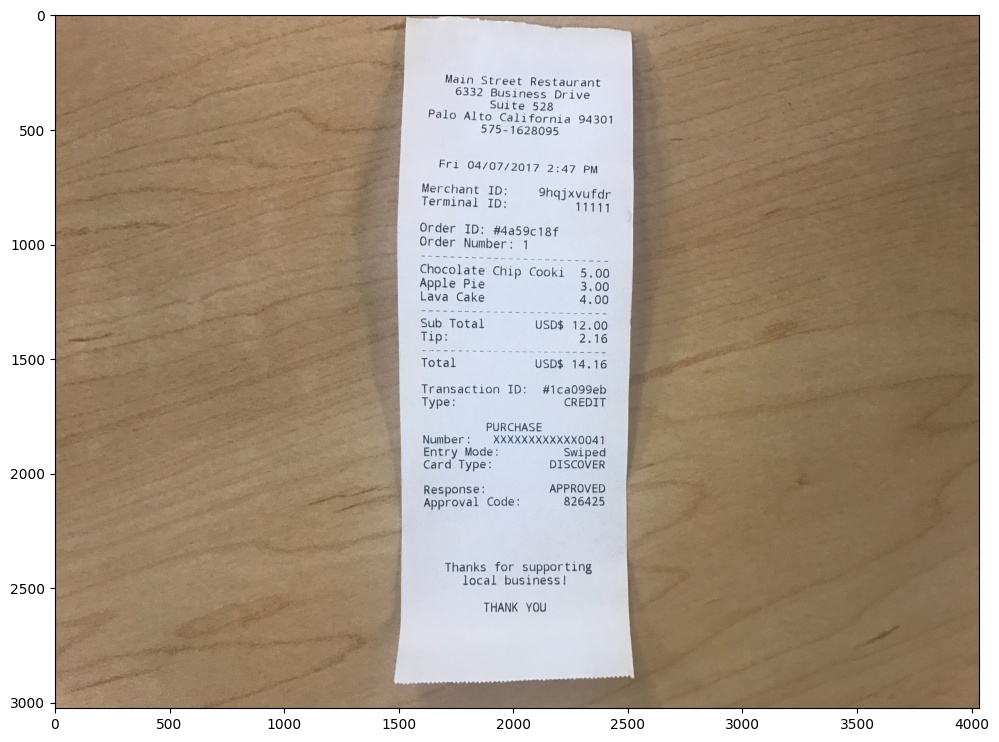

In [6]:
test_image = Image.open('inference_data/image_1.jpeg').convert('RGB')

plt.figure(figsize=(12, 9))
plt.imshow(test_image)
plt.show()

In [7]:
def test(model, processor, image, max_new_tokens=1024, device='cuda'):
    messages = [
        {
            'role': 'user',
            'content': [
                {'type': 'image'},
                {'type': 'text', 'text': 'OCR this image accurately'}
            ]
        },
    ]
    
    # Prepare the text input by applying the chat template
    text_input = processor.apply_chat_template(
        messages,  # Use the sample without the system message
        add_generation_prompt=True
    )

    image_inputs = []
    if image.mode != 'RGB':
        image = image.convert('RGB')
        
    image_inputs.append([image])

    # Prepare the inputs for the model
    model_inputs = processor(
        #text=[text_input],
        text=text_input,
        images=image_inputs,
        return_tensors='pt',
    ).to(device)  # Move inputs to the specified device

    # Generate text with the model
    generated_ids = model.generate(**model_inputs, max_new_tokens=max_new_tokens)

    # Trim the generated ids to remove the input ids
    trimmed_generated_ids = [
        out_ids[len(in_ids):] for in_ids, out_ids in zip(model_inputs.input_ids, generated_ids)
    ]

    # Decode the output text
    output_text = processor.batch_decode(
        trimmed_generated_ids, 
        skip_special_tokens=True,
        clean_up_tokenization_spaces=False
    )

    return output_text[0]  # Return the first decoded output text

In [8]:
output = test(model, processor, test_image)
print(output)

 Main Street Restaurant 6332 Business Drive 6332 Business Drive Suite 528 575-1628095 Palo Alto California 94301 FRI 04/07/2017 2:47 PM Merchant ID: 9hqjxvuvd 11111 Terminal ID: 9hqjxvuvd 11111 Order ID: #4a59c18f Order Number: 1 1 Chocolate Chip Cookie 5.00 Apple Pie 3.00 Lava Cake 4.00 Sub Total 12.00 Tip: 2.16 Total 14.16 Transaction ID: #1ca0996eb CREDIT Number: PURCHASE XXXX XXXX XXXX Entry Mode: Swiped Card Type: DISCOVER APPROVED 826425 Approval Code: 826425 Thanks for supporting local business! THANK YOU
